# LightModel Example

You can install torchkeras using pip:
`pip install torchkeras`

Here is a complete example using torchkeras.LightModel 

In [ ]:
!pip install -U torchmetrics

In [ ]:
import sys 
sys.path.append("..")

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

import torchkeras #Attention this line 


### 1, prepare data 

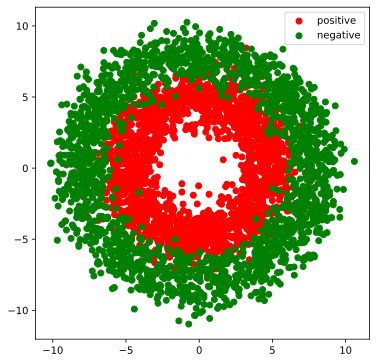

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#number of samples
n_positive,n_negative = 2000,2000

#positive samples
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#negative samples
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#concat positive and negative samples
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#visual samples
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);


In [4]:
# split samples into train and valid data.
ds = TensorDataset(X,Y)
ds_train,ds_val = torch.utils.data.random_split(ds,[int(len(ds)*0.7),len(ds)-int(len(ds)*0.7)])
dl_train = DataLoader(ds_train,batch_size = 200,shuffle=True,num_workers=2)
dl_val = DataLoader(ds_val,batch_size = 200,num_workers=2)


In [5]:
for features,labels in dl_train:
    break
print(features.shape)
print(labels.shape)


torch.Size([200, 2])
torch.Size([200, 1])


### 2, create the  model

In [6]:
class Net(nn.Module):  
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x) #don't need nn.Sigmoid()
        return y
    

In [7]:
import pytorch_lightning as pl 
from torchmetrics.classification import BinaryAccuracy
#from torchkeras.metrics import Accuracy

net = Net()
loss_fn = nn.BCEWithLogitsLoss()

metric_dict = {"acc":BinaryAccuracy(threshold=0.5)}

optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)

model = torchkeras.LightModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metric_dict,
                   optimizer = optimizer,
                   lr_scheduler = lr_scheduler,
                  )       

from torchkeras import summary
summary(model,input_data=features);


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Linear-1                                     [-1, 4]                   12
Linear-2                                     [-1, 8]                   40
Linear-3                                     [-1, 1]                    9
Total params: 61
Trainable params: 61
Non-trainable params: 0
--------------------------------------------------------------------------
Input size (MB): 0.000069
Forward/backward pass size (MB): 0.000099
Params size (MB): 0.000233
Estimated Total Size (MB): 0.000401
--------------------------------------------------------------------------


/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  rank_zero_warn(
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  rank_zero_warn(


### 3, train the model

In [8]:
import pytorch_lightning as pl     

#1，设置回调函数
model_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    save_top_k=1,
    mode='max'
)

early_stopping = pl.callbacks.EarlyStopping(monitor = 'val_acc',
                           patience=3,
                           mode = 'max'
                          )

#2，设置训练参数
trainer = pl.Trainer(logger=True,
                     min_epochs=3,max_epochs=20,
                     accelerator='cpu', #mps/gpu/cpu
                     devices=1,
                     callbacks = [model_ckpt,early_stopping],
                     enable_progress_bar = True) 

#断点续训
#trainer = pl.Trainer(resume_from_checkpoint='./lightning_logs/version_31/checkpoints/epoch=02-val_loss=0.05.ckpt')

##4，启动训练循环
trainer.fit(model,dl_train,dl_val)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name          | Type              | Params
----------------------------------------------------
0 | net           | Net               | 61    
1 | train_metrics | ModuleDict        | 0     
2 | val_metrics   | ModuleDict        | 0     
3 | test_metrics  | ModuleDict        | 0     
4 | loss_fn       | BCEWithLogitsLoss | 0     
----------------------------------------------------
61        Trainable params
0         Non-trainable params
61        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



================================================================================2023-01-19 21:53:48
{'epoch': 0, 'val_loss': 0.7145189046859741, 'val_acc': 0.5699999928474426}


<<<<<< reach best val_acc : 0.5699999928474426 >>>>>>
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:49
{'epoch': 0, 'val_loss': 0.5771281719207764, 'val_acc': 0.6650000214576721}
{'epoch': 0, 'train_loss': 0.649939239025116, 'train_acc': 0.6171428561210632}


<<<<<< reach best val_acc : 0.6650000214576721 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:51
{'epoch': 1, 'val_loss': 0.3992978632450104, 'val_acc': 0.9083333611488342}
{'epoch': 1, 'train_loss': 0.5018996596336365, 'train_acc': 0.7953571677207947}


<<<<<< reach best val_acc : 0.9083333611488342 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:52
{'epoch': 2, 'val_loss': 0.285995215177536, 'val_acc': 0.9108333587646484}
{'epoch': 2, 'train_loss': 0.3498070538043976, 'train_acc': 0.8864285945892334}


<<<<<< reach best val_acc : 0.9108333587646484 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:53
{'epoch': 3, 'val_loss': 0.2559534013271332, 'val_acc': 0.9108333587646484}
{'epoch': 3, 'train_loss': 0.273407906293869, 'train_acc': 0.9010714292526245}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:54
{'epoch': 4, 'val_loss': 0.23370049893856049, 'val_acc': 0.9150000214576721}
{'epoch': 4, 'train_loss': 0.2525629699230194, 'train_acc': 0.9032142758369446}


<<<<<< reach best val_acc : 0.9150000214576721 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:55
{'epoch': 5, 'val_loss': 0.25066855549812317, 'val_acc': 0.9024999737739563}
{'epoch': 5, 'train_loss': 0.22457075119018555, 'train_acc': 0.9135714173316956}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:56
{'epoch': 6, 'val_loss': 0.20776985585689545, 'val_acc': 0.9316666722297668}
{'epoch': 6, 'train_loss': 0.2181021124124527, 'train_acc': 0.9157142639160156}


<<<<<< reach best val_acc : 0.9316666722297668 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:57
{'epoch': 7, 'val_loss': 0.1987377554178238, 'val_acc': 0.9191666841506958}
{'epoch': 7, 'train_loss': 0.20715726912021637, 'train_acc': 0.9203571677207947}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:58
{'epoch': 8, 'val_loss': 0.18021941184997559, 'val_acc': 0.9325000047683716}
{'epoch': 8, 'train_loss': 0.20035259425640106, 'train_acc': 0.9210714101791382}


<<<<<< reach best val_acc : 0.9325000047683716 >>>>>>


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:53:59
{'epoch': 9, 'val_loss': 0.20309142768383026, 'val_acc': 0.9200000166893005}
{'epoch': 9, 'train_loss': 0.19551290571689606, 'train_acc': 0.9260714054107666}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:54:00
{'epoch': 10, 'val_loss': 0.2029733806848526, 'val_acc': 0.9200000166893005}
{'epoch': 10, 'train_loss': 0.20322643220424652, 'train_acc': 0.9196428656578064}


Validation: 0it [00:00, ?it/s]


================================================================================2023-01-19 21:54:02
{'epoch': 11, 'val_loss': 0.20276819169521332, 'val_acc': 0.9200000166893005}
{'epoch': 11, 'train_loss': 0.2030951976776123, 'train_acc': 0.9196428656578064}


/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'y_pred')

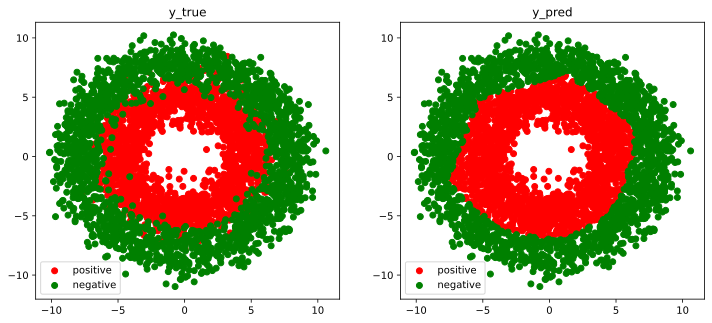

In [9]:
# visual the results
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true")

Xp_pred = X[torch.squeeze(F.sigmoid(model.forward(X))>=0.5)]
Xn_pred = X[torch.squeeze(F.sigmoid(model.forward(X))<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred")


### 4, evaluate the model

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

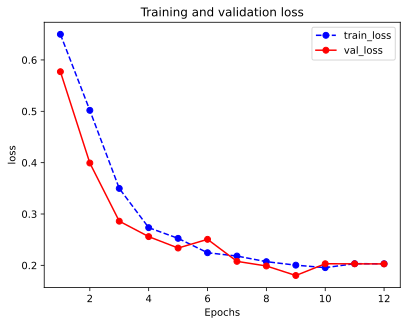

In [11]:
dfhistory  = model.get_history() 
plot_metric(dfhistory,"loss")

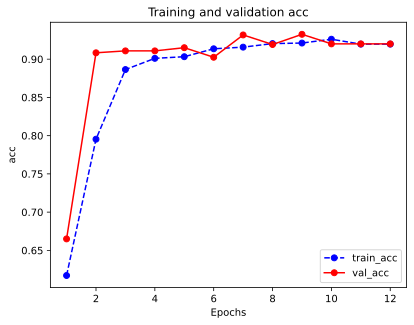

In [12]:
plot_metric(dfhistory,"acc")

In [13]:
#使用最佳保存点进行评估
trainer.test(ckpt_path='best', dataloaders=dl_val,verbose = False)

Restoring states from the checkpoint path at /Users/liangyun2/CodeFiles/torchkeras/lightning_logs/version_11/checkpoints/epoch=8-step=126.ckpt
Loaded model weights from checkpoint at /Users/liangyun2/CodeFiles/torchkeras/lightning_logs/version_11/checkpoints/epoch=8-step=126.ckpt
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

{'test_loss': 0.18021941184997559, 'test_acc': 0.9325000047683716}


[{'test_loss': 0.18021941184997559, 'test_acc': 0.9325000047683716}]

### 5, use the model

In [14]:
predictions = torch.sigmoid(torch.cat(trainer.predict(model, dl_val, ckpt_path='best'))) 


Restoring states from the checkpoint path at /Users/liangyun2/CodeFiles/torchkeras/lightning_logs/version_11/checkpoints/epoch=8-step=126.ckpt
Loaded model weights from checkpoint at /Users/liangyun2/CodeFiles/torchkeras/lightning_logs/version_11/checkpoints/epoch=8-step=126.ckpt
/Users/liangyun2/miniforge3/envs/tf26/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 14it [00:00, ?it/s]

In [15]:
def predict(model,dl):
    model.eval()
    result = torch.cat([model.forward(t[0]) for t in dl])
    return(result.data)

predictions = torch.sigmoid(predict(model,dl_val)[:10]) 


### 6, save the model

In [ ]:
print(trainer.checkpoint_callback.best_model_path)
print(trainer.checkpoint_callback.best_model_score)

In [ ]:
model_best = torchkeras.LightModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path)

In [ ]:
best_net = model_best.net 
torch.save(best_net.state_dict(),"best_net.pt")

In [ ]:
#加载权重
net_clone = Net()
net_clone.load_state_dict(torch.load("best_net.pt"))

In [ ]:
#验证net_clone和model_best推理结果完全一致。
data,label = next(iter(dl_val))

model_best.eval()
net_clone.eval() 
with torch.no_grad():
    preds  = model_best(data)
    preds_clone = net_clone(data)
    
print("model_best prediction:\n",preds[0:10],"\n")
print("net_clone prediction:\n",preds_clone[0:10])